# Анализ данных управления затратами

Этот notebook содержит полный анализ данных из файла `cost_management_survey_results_10000.csv`, включая:
1. Загрузку и первичный анализ данных
2. Очистку от пустых значений
3. Загрузку в PostgreSQL
4. Создание аналитических витрин
5. Подготовку данных для DataLens


In [6]:
!pip install psycopg2-binary
!pip install seaborn
!pip install sqlalchemy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 73.2 kB/s eta 0:00:00a 0:00:03m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 607.6/607.6 kB 68.1 kB/s eta 0:00:00a 0:00:02


In [7]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import psycopg2
from psycopg2.extras import RealDictCursor
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')

# Настройка отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Библиотеки успешно импортированы!")


Библиотеки успешно импортированы!


## 1. Загрузка и первичный анализ данных


In [8]:
# Загрузка данных из CSV
df = pd.read_csv('cost_management_survey_results_10000.csv')

print(f"Размер датасета: {df.shape}")
print(f"Количество записей: {len(df)}")
print(f"Количество столбцов: {len(df.columns)}")
print("\nПервые 5 строк:")
df.head()


Размер датасета: (10000, 12)
Количество записей: 10000
Количество столбцов: 12

Первые 5 строк:


,record_id,timestamp,department,data_system,cost_category,planned_costs,actual_costs,cost_optimization_strategy,satisfaction_level,employee_count,cost_deviation,cost_per_employee
0,1,2023-02-06 13:36:39,HR,ERP,Заработная плата персонала,57140,49600,Повышение квалификации сотрудников,Недоволен,259,-7540,191.51
1,2,2024-06-09 01:13:58,Маркетинг,ERP,Лицензии на ПО,75778,92919,Автоматизация рутинных задач,Очень недоволен,185,17141,502.26
2,3,2023-01-16 21:49:03,ИТ,CRM,Обслуживание оборудования,57877,50091,Переход на ПО с открытым исходным кодом,Недоволен,358,-7786,139.92
3,4,2024-02-19 13:25:41,Маркетинг,ERP,Лицензии на ПО,70022,86830,Автоматизация рутинных задач,Нейтрально,261,16808,332.68
4,5,2024-11-01 11:12:08,Производство,ERP,Заработная плата персонала,52388,52905,Централизация закупок ПО,Доволен,382,517,138.49


In [9]:
# Анализ структуры данных
print("Информация о столбцах:")
print(df.info())
print("\nОписательная статистика:")
df.describe()


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   record_id                   10000 non-null  int64  
 1   timestamp                   10000 non-null  object 
 2   department                  10000 non-null  object 
 3   data_system                 10000 non-null  object 
 4   cost_category               10000 non-null  object 
 5   planned_costs               10000 non-null  int64  
 6   actual_costs                10000 non-null  int64  
 7   cost_optimization_strategy  10000 non-null  object 
 8   satisfaction_level          10000 non-null  object 
 9   employee_count              10000 non-null  int64  
 10  cost_deviation              10000 non-null  int64  
 11  cost_per_employee           10000 non-null  float64
dtypes: float64(1), int64(5), object(6)
memory usage: 937.6+ KB
None

О

,record_id,planned_costs,actual_costs,employee_count,cost_deviation,cost_per_employee
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,52316.229700,55029.950200,255.063900,2713.720500,447.253886
std,2886.89568,27299.018717,29607.851831,141.680317,6972.850361,804.875725
min,1.00000,5002.000000,4327.000000,10.000000,-14858.000000,10.170000
25%,2500.75000,29133.500000,30048.500000,134.000000,-1708.750000,115.637500
50%,5000.50000,52194.000000,53932.500000,254.000000,1618.000000,214.685000
75%,7500.25000,75872.250000,78710.250000,378.000000,6748.000000,407.790000
max,10000.00000,99972.000000,124535.000000,499.000000,24875.000000,11713.400000


In [10]:
# Проверка на пропущенные значения
print("Пропущенные значения по столбцам:")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Количество пропусков': missing_values,
    'Процент пропусков': missing_percent
})

print(missing_df[missing_df['Количество пропусков'] > 0])

# Общая статистика по пропускам
total_missing = df.isnull().sum().sum()
print(f"\nОбщее количество пропущенных значений: {total_missing}")
print(f"Процент пропущенных значений: {(total_missing / (len(df) * len(df.columns))) * 100:.2f}%")


Пропущенные значения по столбцам:
Empty DataFrame
Columns: [Количество пропусков, Процент пропусков]
Index: []

Общее количество пропущенных значений: 0
Процент пропущенных значений: 0.00%


In [11]:
# Анализ уникальных значений в категориальных столбцах
categorical_columns = ['department', 'data_system', 'cost_category', 'cost_optimization_strategy', 'satisfaction_level']

print("Уникальные значения в категориальных столбцах:")
for col in categorical_columns:
    unique_count = df[col].nunique()
    print(f"\n{col}: {unique_count} уникальных значений")
    print(df[col].value_counts().head(10))


Уникальные значения в категориальных столбцах:

department: 8 уникальных значений
department
ИТ                           1999
Продажи                      1499
Маркетинг                    1448
Производство                 1040
HR                           1027
Финансы                      1007
Исследования и разработка     995
Логистика                     985
Name: count, dtype: int64

data_system: 7 уникальных значений
data_system
ERP                              1487
Хранилище данных                 1460
ETL-инструменты                  1432
Data Lake                        1416
Система управленческого учета    1411
CRM                              1399
BI-платформа                     1395
Name: count, dtype: int64

cost_category: 6 уникальных значений
cost_category
Лицензии на ПО                1743
Обслуживание оборудования     1705
Консалтинг                    1686
Заработная плата персонала    1642
Обучение сотрудников          1613
Облачные сервисы              1611
Name: c

## 2. Визуализация данных


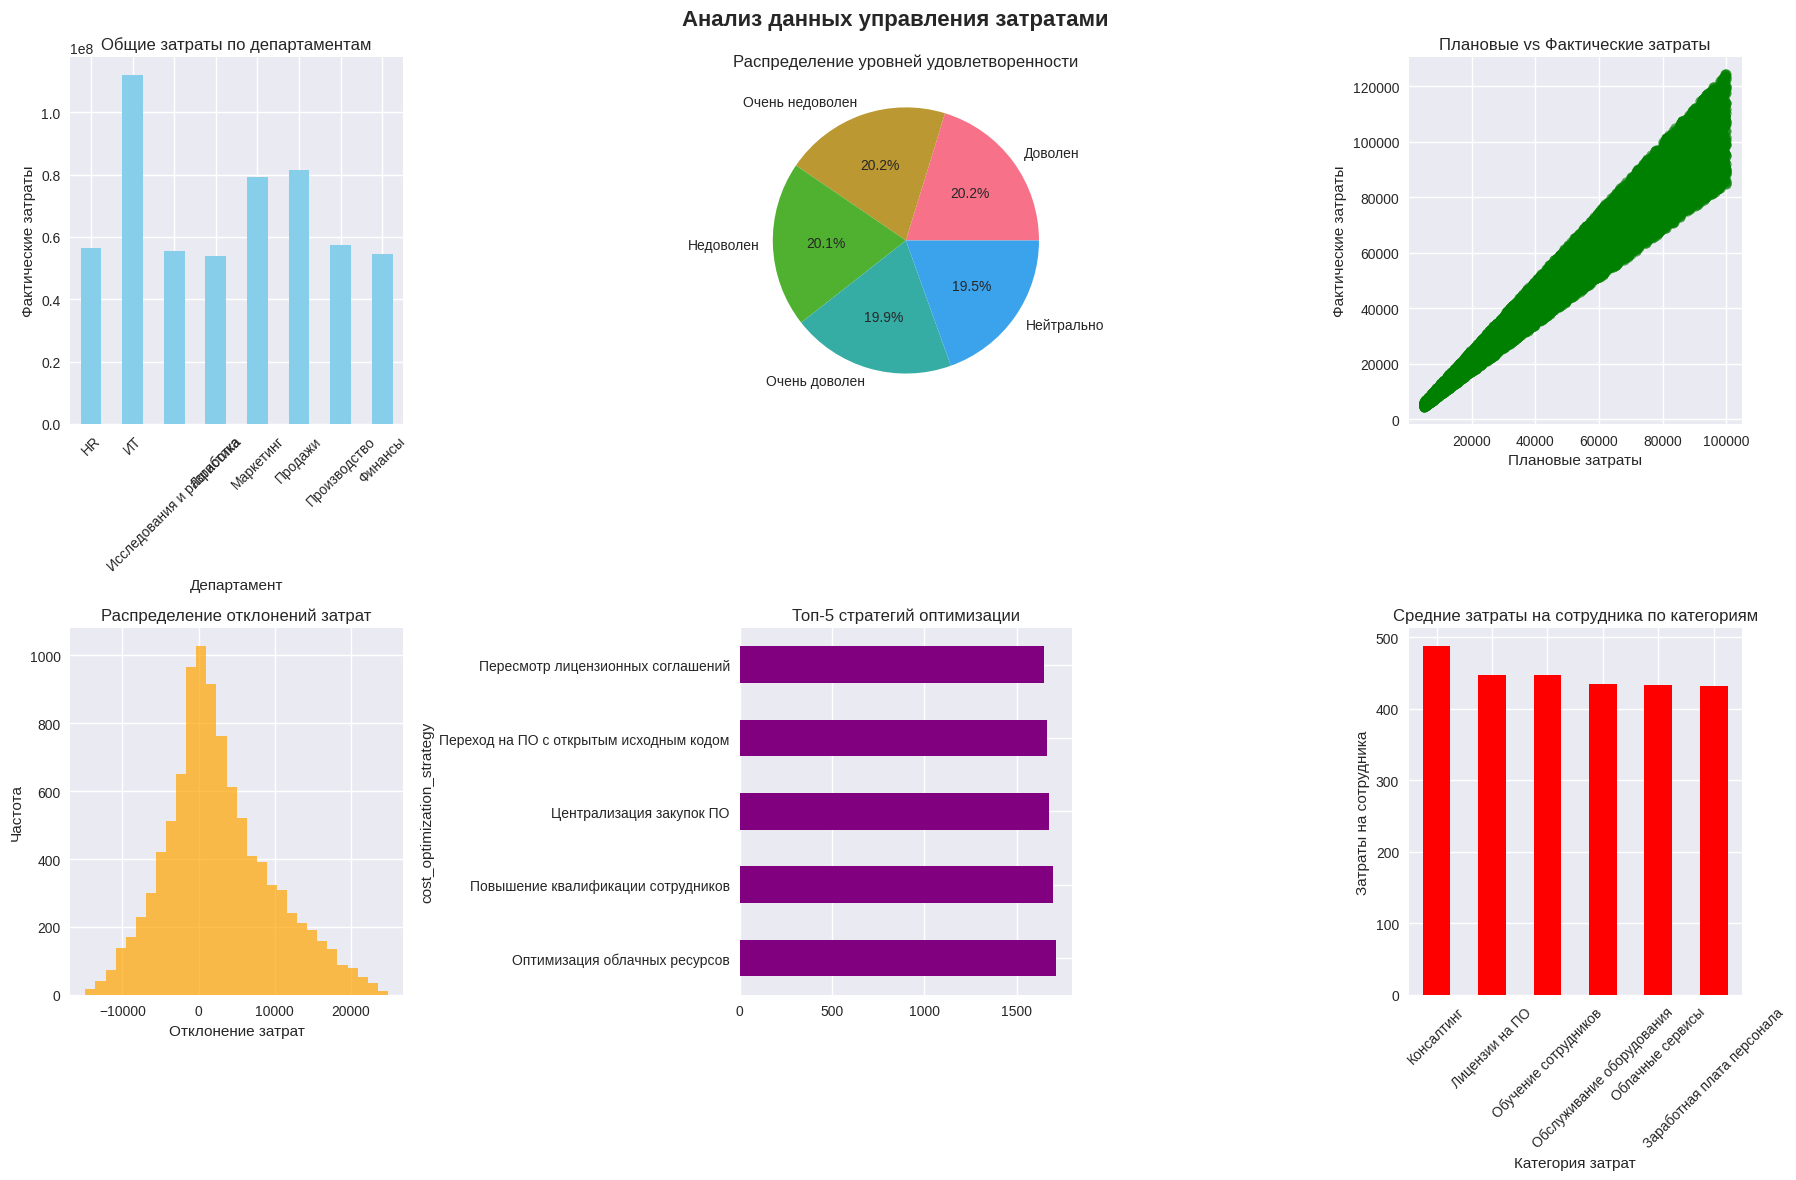

In [12]:
# Создание визуализаций
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Анализ данных управления затратами', fontsize=16, fontweight='bold')

# 1. Распределение затрат по департаментам
df.groupby('department')['actual_costs'].sum().plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Общие затраты по департаментам')
axes[0,0].set_xlabel('Департамент')
axes[0,0].set_ylabel('Фактические затраты')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Распределение уровней удовлетворенности
satisfaction_counts = df['satisfaction_level'].value_counts()
axes[0,1].pie(satisfaction_counts.values, labels=satisfaction_counts.index, autopct='%1.1f%%')
axes[0,1].set_title('Распределение уровней удовлетворенности')

# 3. Корреляция между плановыми и фактическими затратами
axes[0,2].scatter(df['planned_costs'], df['actual_costs'], alpha=0.6, color='green')
axes[0,2].set_title('Плановые vs Фактические затраты')
axes[0,2].set_xlabel('Плановые затраты')
axes[0,2].set_ylabel('Фактические затраты')

# 4. Распределение отклонений затрат
axes[1,0].hist(df['cost_deviation'], bins=30, color='orange', alpha=0.7)
axes[1,0].set_title('Распределение отклонений затрат')
axes[1,0].set_xlabel('Отклонение затрат')
axes[1,0].set_ylabel('Частота')

# 5. Топ-5 стратегий оптимизации
top_strategies = df['cost_optimization_strategy'].value_counts().head(5)
top_strategies.plot(kind='barh', ax=axes[1,1], color='purple')
axes[1,1].set_title('Топ-5 стратегий оптимизации')

# 6. Затраты на сотрудника по категориям
cost_per_employee_by_category = df.groupby('cost_category')['cost_per_employee'].mean().sort_values(ascending=False)
cost_per_employee_by_category.plot(kind='bar', ax=axes[1,2], color='red')
axes[1,2].set_title('Средние затраты на сотрудника по категориям')
axes[1,2].set_xlabel('Категория затрат')
axes[1,2].set_ylabel('Затраты на сотрудника')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 3. Очистка данных


In [13]:
# Очистка данных
print("Данные до очистки:")
print(f"Количество строк: {len(df)}")
print(f"Пропущенные значения: {df.isnull().sum().sum()}")

# Удаление строк с критическими пропусками
df_clean = df.dropna(subset=['department', 'cost_category', 'planned_costs', 'actual_costs'])

# Заполнение пропусков в числовых столбцах медианными значениями
numeric_columns = ['employee_count', 'cost_deviation', 'cost_per_employee']
for col in numeric_columns:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# Заполнение пропусков в категориальных столбцах модой
categorical_columns = ['data_system', 'cost_optimization_strategy', 'satisfaction_level']
for col in categorical_columns:
    if col in df_clean.columns:
        mode_value = df_clean[col].mode()[0] if not df_clean[col].mode().empty else 'Не указано'
        df_clean[col] = df_clean[col].fillna(mode_value)

print("\nДанные после очистки:")
print(f"Количество строк: {len(df_clean)}")
print(f"Пропущенные значения: {df_clean.isnull().sum().sum()}")

# Проверка на дубликаты
duplicates = df_clean.duplicated().sum()
print(f"Количество дубликатов: {duplicates}")

if duplicates > 0:
    df_clean = df_clean.drop_duplicates()
    print(f"Дубликаты удалены. Осталось строк: {len(df_clean)}")


Данные до очистки:
Количество строк: 10000
Пропущенные значения: 0

Данные после очистки:
Количество строк: 10000
Пропущенные значения: 0
Количество дубликатов: 0


## 4. Подключение к PostgreSQL и создание схемы


In [14]:
# Параметры подключения к PostgreSQL
DB_CONFIG = {
    'host': 'localhost',
    'port': 5432,
    'database': 'superstore',
    'user': 'postgres',
    'password': 'post1616!'
}

# Создание строки подключения для SQLAlchemy
connection_string = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"

try:
    # Подключение через psycopg2 для выполнения SQL команд
    conn = psycopg2.connect(**DB_CONFIG)
    conn.autocommit = True
    cursor = conn.cursor()
    
    # Создание схемы для сырых данных
    cursor.execute("""
        CREATE SCHEMA IF NOT EXISTS raw_data;
    """)
    
    # Создание схемы для аналитических витрин
    cursor.execute("""
        CREATE SCHEMA IF NOT EXISTS analytics;
    """)
    
    print("Схемы успешно созданы!")
    
    # Проверка существования схем
    cursor.execute("""
        SELECT schema_name 
        FROM information_schema.schemata 
        WHERE schema_name IN ('raw_data', 'analytics');
    """)
    
    schemas = cursor.fetchall()
    print("Созданные схемы:", [schema[0] for schema in schemas])
    
except Exception as e:
    print(f"Ошибка подключения к базе данных: {e}")
finally:
    if 'cursor' in locals():
        cursor.close()
    if 'conn' in locals():
        conn.close()


Схемы успешно созданы!
Созданные схемы: ['analytics', 'raw_data']


In [15]:
# Создание таблицы для сырых данных
# Альтернативно: можно выполнить SQL скрипт sql/database_setup.sql через pgAdmin
try:
    conn = psycopg2.connect(**DB_CONFIG)
    conn.autocommit = True
    cursor = conn.cursor()
    
    # Удаление таблицы если существует
    cursor.execute("DROP TABLE IF EXISTS raw_data.cost_survey_results;")
    
    # Создание таблицы
    cursor.execute("""
        CREATE TABLE raw_data.cost_survey_results (
            record_id INTEGER PRIMARY KEY,
            timestamp TIMESTAMP,
            department VARCHAR(100),
            data_system VARCHAR(100),
            cost_category VARCHAR(100),
            planned_costs DECIMAL(15,2),
            actual_costs DECIMAL(15,2),
            cost_optimization_strategy VARCHAR(200),
            satisfaction_level VARCHAR(50),
            employee_count INTEGER,
            cost_deviation DECIMAL(15,2),
            cost_per_employee DECIMAL(15,2)
        );
    """)
    
    print("Таблица raw_data.cost_survey_results успешно создана!")
    
except Exception as e:
    print(f"Ошибка создания таблицы: {e}")
finally:
    if 'cursor' in locals():
        cursor.close()
    if 'conn' in locals():
        conn.close()


Таблица raw_data.cost_survey_results успешно создана!


## 5. Загрузка данных в PostgreSQL


In [16]:
# Загрузка очищенных данных в PostgreSQL
try:
    # Создание движка SQLAlchemy
    engine = create_engine(connection_string)
    
    # Загрузка данных
    df_clean.to_sql(
        'cost_survey_results', 
        engine, 
        schema='raw_data', 
        if_exists='replace', 
        index=False,
        method='multi'
    )
    
    print(f"Данные успешно загружены в таблицу raw_data.cost_survey_results")
    print(f"Загружено {len(df_clean)} записей")
    
    # Проверка загрузки
    conn = psycopg2.connect(**DB_CONFIG)
    cursor = conn.cursor()
    cursor.execute("SELECT COUNT(*) FROM raw_data.cost_survey_results;")
    count = cursor.fetchone()[0]
    print(f"Проверка: в таблице {count} записей")
    
    # Показать первые несколько записей
    cursor.execute("SELECT * FROM raw_data.cost_survey_results LIMIT 5;")
    sample_data = cursor.fetchall()
    print("\nПервые 5 записей из БД:")
    for row in sample_data:
        print(row)
    
except Exception as e:
    print(f"Ошибка загрузки данных: {e}")
finally:
    if 'cursor' in locals():
        cursor.close()
    if 'conn' in locals():
        conn.close()


Данные успешно загружены в таблицу raw_data.cost_survey_results
Загружено 10000 записей
Проверка: в таблице 10000 записей

Первые 5 записей из БД:
(1, '2023-02-06 13:36:39', 'HR', 'ERP', 'Заработная плата персонала', 57140, 49600, 'Повышение квалификации сотрудников', 'Недоволен', 259, -7540, 191.51)
(2, '2024-06-09 01:13:58', 'Маркетинг', 'ERP', 'Лицензии на ПО', 75778, 92919, 'Автоматизация рутинных задач', 'Очень недоволен', 185, 17141, 502.26)
(3, '2023-01-16 21:49:03', 'ИТ', 'CRM', 'Обслуживание оборудования', 57877, 50091, 'Переход на ПО с открытым исходным кодом', 'Недоволен', 358, -7786, 139.92)
(4, '2024-02-19 13:25:41', 'Маркетинг', 'ERP', 'Лицензии на ПО', 70022, 86830, 'Автоматизация рутинных задач', 'Нейтрально', 261, 16808, 332.68)
(5, '2024-11-01 11:12:08', 'Производство', 'ERP', 'Заработная плата персонала', 52388, 52905, 'Централизация закупок ПО', 'Доволен', 382, 517, 138.49)


## 6. Создание аналитических витрин


In [17]:
# Создание витрины для консультантов
try:
    conn = psycopg2.connect(**DB_CONFIG)
    conn.autocommit = True
    cursor = conn.cursor()
    
    # Удаление витрины если существует
    cursor.execute("DROP TABLE IF EXISTS analytics.mart_consultant_metrics;")
    
    # Создание витрины для консультантов
    cursor.execute("""
        CREATE TABLE analytics.mart_consultant_metrics AS
        SELECT 
            department,
            cost_category,
            cost_optimization_strategy,
            satisfaction_level,
            COUNT(*) as total_records,
            AVG(planned_costs) as avg_planned_costs,
            AVG(actual_costs) as avg_actual_costs,
            AVG(cost_deviation) as avg_cost_deviation,
            AVG(cost_per_employee) as avg_cost_per_employee,
            AVG(employee_count) as avg_employee_count,
            SUM(actual_costs) as total_actual_costs,
            SUM(planned_costs) as total_planned_costs,
            SUM(cost_deviation) as total_cost_deviation,
            -- Расчет эффективности стратегий
            CASE 
                WHEN AVG(cost_deviation) < 0 THEN 'Эффективная'
                WHEN AVG(cost_deviation) BETWEEN 0 AND 10000 THEN 'Умеренно эффективная'
                ELSE 'Неэффективная'
            END as strategy_effectiveness,
            -- Расчет уровня риска
            CASE 
                WHEN STDDEV(cost_deviation) > 20000 THEN 'Высокий'
                WHEN STDDEV(cost_deviation) BETWEEN 10000 AND 20000 THEN 'Средний'
                ELSE 'Низкий'
            END as risk_level
        FROM raw_data.cost_survey_results
        GROUP BY department, cost_category, cost_optimization_strategy, satisfaction_level;
    """)
    
    print("Витрина analytics.mart_consultant_metrics создана!")
    
    # Проверка количества записей
    cursor.execute("SELECT COUNT(*) FROM analytics.mart_consultant_metrics;")
    count = cursor.fetchone()[0]
    print(f"Количество записей в витрине: {count}")
    
except Exception as e:
    print(f"Ошибка создания витрины консультантов: {e}")
finally:
    if 'cursor' in locals():
        cursor.close()
    if 'conn' in locals():
        conn.close()


Витрина analytics.mart_consultant_metrics создана!
Количество записей в витрине: 1436


In [18]:
# Создание витрины для HR и рекрутеров
try:
    conn = psycopg2.connect(**DB_CONFIG)
    conn.autocommit = True
    cursor = conn.cursor()
    
    # Удаление витрины если существует
    cursor.execute("DROP TABLE IF EXISTS analytics.mart_hr_recruitment_metrics;")
    
    # Создание витрины для HR
    cursor.execute("""
        CREATE TABLE analytics.mart_hr_recruitment_metrics AS
        SELECT 
            department,
            cost_category,
            cost_optimization_strategy,
            COUNT(*) as total_records,
            AVG(employee_count) as avg_employee_count,
            AVG(cost_per_employee) as avg_cost_per_employee,
            SUM(actual_costs) as total_costs,
            AVG(actual_costs) as avg_costs,
            -- Анализ зарплатных затрат
            CASE 
                WHEN cost_category = 'Заработная плата персонала' THEN 'Зарплатные затраты'
                WHEN cost_category = 'Обучение сотрудников' THEN 'Инвестиции в развитие'
                ELSE 'Прочие затраты'
            END as cost_type,
            -- Расчет ROI от обучения
            CASE 
                WHEN cost_category = 'Обучение сотрудников' AND AVG(cost_deviation) < 0 
                THEN 'Положительный ROI'
                WHEN cost_category = 'Обучение сотрудников' AND AVG(cost_deviation) >= 0 
                THEN 'Отрицательный ROI'
                ELSE 'Не применимо'
            END as training_roi,
            -- Уровень компетенций (на основе стратегий оптимизации)
            CASE 
                WHEN cost_optimization_strategy LIKE '%квалификации%' OR 
                     cost_optimization_strategy LIKE '%обучения%' THEN 'Высокие требования к компетенциям'
                WHEN cost_optimization_strategy LIKE '%автоматизации%' THEN 'Технические компетенции'
                ELSE 'Базовые компетенции'
            END as competency_level,
            -- Рекомендации по найму
            CASE 
                WHEN AVG(cost_per_employee) > 500 AND cost_category = 'Заработная плата персонала'
                THEN 'Требуются высококвалифицированные специалисты'
                WHEN AVG(cost_per_employee) BETWEEN 200 AND 500 AND cost_category = 'Заработная плата персонала'
                THEN 'Средний уровень квалификации достаточен'
                ELSE 'Базовые навыки достаточны'
            END as hiring_recommendation
        FROM raw_data.cost_survey_results
        GROUP BY department, cost_category, cost_optimization_strategy;
    """)
    
    print("Витрина analytics.mart_hr_recruitment_metrics создана!")
    
    # Проверка количества записей
    cursor.execute("SELECT COUNT(*) FROM analytics.mart_hr_recruitment_metrics;")
    count = cursor.fetchone()[0]
    print(f"Количество записей в витрине: {count}")
    
except Exception as e:
    print(f"Ошибка создания витрины HR: {e}")
finally:
    if 'cursor' in locals():
        cursor.close()
    if 'conn' in locals():
        conn.close()


Витрина analytics.mart_hr_recruitment_metrics создана!
Количество записей в витрине: 288


In [19]:
# Создание витрины для стратегического планирования компании
try:
    conn = psycopg2.connect(**DB_CONFIG)
    conn.autocommit = True
    cursor = conn.cursor()
    
    # Удаление витрины если существует
    cursor.execute("DROP TABLE IF EXISTS analytics.mart_company_strategy_metrics;")
    
    # Создание витрины для стратегического планирования
    cursor.execute("""
        CREATE TABLE analytics.mart_company_strategy_metrics AS
        SELECT 
            department,
            data_system,
            cost_category,
            cost_optimization_strategy,
            COUNT(*) as total_records,
            AVG(planned_costs) as avg_planned_costs,
            AVG(actual_costs) as avg_actual_costs,
            AVG(cost_deviation) as avg_cost_deviation,
            AVG(cost_per_employee) as avg_cost_per_employee,
            SUM(actual_costs) as total_actual_costs,
            SUM(planned_costs) as total_planned_costs,
            SUM(cost_deviation) as total_cost_deviation,
            -- Расчет эффективности управления затратами
            CASE 
                WHEN AVG(cost_deviation) < -5000 THEN 'Высокая эффективность'
                WHEN AVG(cost_deviation) BETWEEN -5000 AND 5000 THEN 'Средняя эффективность'
                ELSE 'Низкая эффективность'
            END as cost_management_effectiveness,
            -- Анализ технологических решений
            CASE 
                WHEN data_system IN ('ERP', 'CRM') THEN 'Корпоративные системы'
                WHEN data_system IN ('Data Lake', 'ETL-инструменты') THEN 'Аналитические системы'
                ELSE 'Прочие системы'
            END as system_category,
            -- Стратегические рекомендации
            CASE 
                WHEN AVG(cost_deviation) > 10000 AND cost_category = 'Лицензии на ПО'
                THEN 'Пересмотреть лицензионную политику'
                WHEN AVG(cost_deviation) > 10000 AND cost_category = 'Облачные сервисы'
                THEN 'Оптимизировать облачные ресурсы'
                WHEN AVG(cost_deviation) < -5000
                THEN 'Масштабировать успешные практики'
                ELSE 'Поддерживать текущий уровень'
            END as strategic_recommendation,
            -- Конкурентные преимущества
            CASE 
                WHEN AVG(cost_per_employee) < 200 AND AVG(cost_deviation) < 0
                THEN 'Высокая операционная эффективность'
                WHEN AVG(cost_deviation) < -10000
                THEN 'Преимущество в управлении затратами'
                ELSE 'Стандартный уровень'
            END as competitive_advantage,
            -- Приоритеты развития
            CASE 
                WHEN cost_optimization_strategy LIKE '%автоматизации%' THEN 'Цифровизация'
                WHEN cost_optimization_strategy LIKE '%квалификации%' THEN 'Развитие персонала'
                WHEN cost_optimization_strategy LIKE '%облачных%' THEN 'Облачные технологии'
                ELSE 'Операционная оптимизация'
            END as development_priority
        FROM raw_data.cost_survey_results
        GROUP BY department, data_system, cost_category, cost_optimization_strategy;
    """)
    
    print("Витрина analytics.mart_company_strategy_metrics создана!")
    
    # Проверка количества записей
    cursor.execute("SELECT COUNT(*) FROM analytics.mart_company_strategy_metrics;")
    count = cursor.fetchone()[0]
    print(f"Количество записей в витрине: {count}")
    
except Exception as e:
    print(f"Ошибка создания витрины стратегического планирования: {e}")
finally:
    if 'cursor' in locals():
        cursor.close()
    if 'conn' in locals():
        conn.close()


Витрина analytics.mart_company_strategy_metrics создана!
Количество записей в витрине: 1990


## 7. Проверка созданных витрин


In [20]:
# Проверка всех созданных таблиц и витрин
try:
    conn = psycopg2.connect(**DB_CONFIG)
    cursor = conn.cursor()
    
    # Получение списка всех таблиц
    cursor.execute("""
        SELECT schemaname, tablename, tableowner 
        FROM pg_tables 
        WHERE schemaname IN ('raw_data', 'analytics')
        ORDER BY schemaname, tablename;
    """)
    
    tables = cursor.fetchall()
    print("Созданные таблицы и витрины:")
    print("-" * 50)
    for table in tables:
        print(f"Схема: {table[0]}, Таблица: {table[1]}, Владелец: {table[2]}")
    
    # Проверка количества записей в каждой таблице
    print("\nКоличество записей в таблицах:")
    print("-" * 50)
    
    table_counts = [
        ('raw_data', 'cost_survey_results'),
        ('analytics', 'mart_consultant_metrics'),
        ('analytics', 'mart_hr_recruitment_metrics'),
        ('analytics', 'mart_company_strategy_metrics')
    ]
    
    for schema, table in table_counts:
        cursor.execute(f"SELECT COUNT(*) FROM {schema}.{table};")
        count = cursor.fetchone()[0]
        print(f"{schema}.{table}: {count} записей")
    
    # Примеры данных из каждой витрины
    print("\nПримеры данных из витрин:")
    print("-" * 50)
    
    # Витрина консультантов
    cursor.execute("SELECT * FROM analytics.mart_consultant_metrics LIMIT 3;")
    consultant_sample = cursor.fetchall()
    print("Витрина консультантов (первые 3 записи):")
    for row in consultant_sample:
        print(row)
    
    print("\n" + "-" * 30)
    
    # Витрина HR
    cursor.execute("SELECT * FROM analytics.mart_hr_recruitment_metrics LIMIT 3;")
    hr_sample = cursor.fetchall()
    print("Витрина HR (первые 3 записи):")
    for row in hr_sample:
        print(row)
    
    print("\n" + "-" * 30)
    
    # Витрина стратегического планирования
    cursor.execute("SELECT * FROM analytics.mart_company_strategy_metrics LIMIT 3;")
    strategy_sample = cursor.fetchall()
    print("Витрина стратегического планирования (первые 3 записи):")
    for row in strategy_sample:
        print(row)
    
except Exception as e:
    print(f"Ошибка проверки витрин: {e}")
finally:
    if 'cursor' in locals():
        cursor.close()
    if 'conn' in locals():
        conn.close()


Созданные таблицы и витрины:
--------------------------------------------------
Схема: analytics, Таблица: mart_company_strategy_metrics, Владелец: postgres
Схема: analytics, Таблица: mart_consultant_metrics, Владелец: postgres
Схема: analytics, Таблица: mart_hr_recruitment_metrics, Владелец: postgres
Схема: raw_data, Таблица: cost_survey_results, Владелец: postgres

Количество записей в таблицах:
--------------------------------------------------
raw_data.cost_survey_results: 10000 записей
analytics.mart_consultant_metrics: 1436 записей
analytics.mart_hr_recruitment_metrics: 288 записей
analytics.mart_company_strategy_metrics: 1990 записей

Примеры данных из витрин:
--------------------------------------------------
Витрина консультантов (первые 3 записи):
('Маркетинг', 'Облачные сервисы', 'Повышение квалификации сотрудников', 'Очень недоволен', 9, Decimal('36638.777777777778'), Decimal('37152.333333333333'), Decimal('513.5555555555555556'), 453.6344444444444, Decimal('217.22222222222

## 8. Подготовка данных для DataLens

### Создание сводных таблиц для дашбордов


In [21]:
# Создание сводных таблиц для DataLens дашбордов
try:
    conn = psycopg2.connect(**DB_CONFIG)
    conn.autocommit = True
    cursor = conn.cursor()
    
    # 1. Сводная таблица по департаментам для консультантов
    cursor.execute("DROP TABLE IF EXISTS analytics.department_summary;")
    cursor.execute("""
        CREATE TABLE analytics.department_summary AS
        SELECT 
            department,
            COUNT(*) as total_projects,
            AVG(planned_costs) as avg_planned_costs,
            AVG(actual_costs) as avg_actual_costs,
            AVG(cost_deviation) as avg_cost_deviation,
            AVG(cost_per_employee) as avg_cost_per_employee,
            SUM(actual_costs) as total_actual_costs,
            SUM(planned_costs) as total_planned_costs,
            SUM(cost_deviation) as total_cost_deviation,
            -- Расчет эффективности по департаментам
            CASE 
                WHEN AVG(cost_deviation) < -5000 THEN 'Высокая эффективность'
                WHEN AVG(cost_deviation) BETWEEN -5000 AND 5000 THEN 'Средняя эффективность'
                ELSE 'Низкая эффективность'
            END as efficiency_level,
            -- Топ стратегии по департаменту
            MODE() WITHIN GROUP (ORDER BY cost_optimization_strategy) as top_strategy,
            -- Уровень удовлетворенности
            MODE() WITHIN GROUP (ORDER BY satisfaction_level) as common_satisfaction
        FROM raw_data.cost_survey_results
        GROUP BY department;
    """)
    
    # 2. Сводная таблица по категориям затрат для HR
    cursor.execute("DROP TABLE IF EXISTS analytics.cost_category_summary;")
    cursor.execute("""
        CREATE TABLE analytics.cost_category_summary AS
        SELECT 
            cost_category,
            COUNT(*) as total_records,
            AVG(employee_count) as avg_employee_count,
            AVG(cost_per_employee) as avg_cost_per_employee,
            SUM(actual_costs) as total_costs,
            AVG(actual_costs) as avg_costs,
            AVG(cost_deviation) as avg_deviation,
            -- Анализ ROI по категориям
            CASE 
                WHEN AVG(cost_deviation) < 0 THEN 'Положительный ROI'
                WHEN AVG(cost_deviation) BETWEEN 0 AND 10000 THEN 'Нейтральный ROI'
                ELSE 'Отрицательный ROI'
            END as roi_status,
            -- Рекомендации по категориям
            CASE 
                WHEN cost_category = 'Заработная плата персонала' AND AVG(cost_per_employee) > 400
                THEN 'Высокие зарплатные ожидания'
                WHEN cost_category = 'Обучение сотрудников' AND AVG(cost_deviation) < 0
                THEN 'Эффективные инвестиции в обучение'
                ELSE 'Стандартные рекомендации'
            END as category_recommendation
        FROM raw_data.cost_survey_results
        GROUP BY cost_category;
    """)
    
    # 3. Сводная таблица по стратегиям оптимизации для компании
    cursor.execute("DROP TABLE IF EXISTS analytics.strategy_summary;")
    cursor.execute("""
        CREATE TABLE analytics.strategy_summary AS
        SELECT 
            cost_optimization_strategy,
            COUNT(*) as total_implementations,
            AVG(planned_costs) as avg_planned_costs,
            AVG(actual_costs) as avg_actual_costs,
            AVG(cost_deviation) as avg_cost_deviation,
            SUM(actual_costs) as total_actual_costs,
            SUM(planned_costs) as total_planned_costs,
            SUM(cost_deviation) as total_cost_deviation,
            -- Эффективность стратегий
            CASE 
                WHEN AVG(cost_deviation) < -10000 THEN 'Очень эффективная'
                WHEN AVG(cost_deviation) BETWEEN -10000 AND -1000 THEN 'Эффективная'
                WHEN AVG(cost_deviation) BETWEEN -1000 AND 1000 THEN 'Нейтральная'
                ELSE 'Неэффективная'
            END as strategy_effectiveness,
            -- Рекомендации по стратегиям
            CASE 
                WHEN AVG(cost_deviation) < -5000 THEN 'Рекомендуется к масштабированию'
                WHEN AVG(cost_deviation) > 10000 THEN 'Требует пересмотра'
                ELSE 'Поддерживать текущий уровень'
            END as strategy_recommendation,
            -- Приоритет внедрения
            CASE 
                WHEN AVG(cost_deviation) < -5000 AND COUNT(*) > 50 THEN 'Высокий приоритет'
                WHEN AVG(cost_deviation) < 0 AND COUNT(*) > 20 THEN 'Средний приоритет'
                ELSE 'Низкий приоритет'
            END as implementation_priority
        FROM raw_data.cost_survey_results
        GROUP BY cost_optimization_strategy;
    """)
    
    print("Сводные таблицы для DataLens созданы!")
    
    # Проверка созданных таблиц
    summary_tables = [
        'analytics.department_summary',
        'analytics.cost_category_summary', 
        'analytics.strategy_summary'
    ]
    
    for table in summary_tables:
        cursor.execute(f"SELECT COUNT(*) FROM {table};")
        count = cursor.fetchone()[0]
        print(f"{table}: {count} записей")
    
except Exception as e:
    print(f"Ошибка создания сводных таблиц: {e}")
finally:
    if 'cursor' in locals():
        cursor.close()
    if 'conn' in locals():
        conn.close()


Сводные таблицы для DataLens созданы!
analytics.department_summary: 8 записей
analytics.cost_category_summary: 6 записей
analytics.strategy_summary: 6 записей


## 9. Итоговый анализ и выводы


In [22]:
# Итоговый анализ данных
try:
    conn = psycopg2.connect(**DB_CONFIG)
    cursor = conn.cursor()
    
    print("=" * 60)
    print("ИТОГОВЫЙ АНАЛИЗ ДАННЫХ УПРАВЛЕНИЯ ЗАТРАТАМИ")
    print("=" * 60)
    
    # Общая статистика
    cursor.execute("""
        SELECT 
            COUNT(*) as total_records,
            COUNT(DISTINCT department) as departments_count,
            COUNT(DISTINCT cost_category) as cost_categories_count,
            COUNT(DISTINCT cost_optimization_strategy) as strategies_count,
            AVG(planned_costs) as avg_planned_costs,
            AVG(actual_costs) as avg_actual_costs,
            AVG(cost_deviation) as avg_cost_deviation,
            AVG(cost_per_employee) as avg_cost_per_employee
        FROM raw_data.cost_survey_results;
    """)
    
    stats = cursor.fetchone()
    print(f"Общее количество записей: {stats[0]:,}")
    print(f"Количество департаментов: {stats[1]}")
    print(f"Количество категорий затрат: {stats[2]}")
    print(f"Количество стратегий оптимизации: {stats[3]}")
    print(f"Средние плановые затраты: {stats[4]:,.2f}")
    print(f"Средние фактические затраты: {stats[5]:,.2f}")
    print(f"Среднее отклонение затрат: {stats[6]:,.2f}")
    print(f"Средние затраты на сотрудника: {stats[7]:,.2f}")
    
    print("\n" + "-" * 60)
    print("ТОП-5 ДЕПАРТАМЕНТОВ ПО ОБЩИМ ЗАТРАТАМ:")
    print("-" * 60)
    
    cursor.execute("""
        SELECT 
            department,
            SUM(actual_costs) as total_costs,
            AVG(cost_deviation) as avg_deviation,
            COUNT(*) as projects_count
        FROM raw_data.cost_survey_results
        GROUP BY department
        ORDER BY total_costs DESC
        LIMIT 5;
    """)
    
    top_departments = cursor.fetchall()
    for i, dept in enumerate(top_departments, 1):
        print(f"{i}. {dept[0]}: {dept[1]:,.2f} (отклонение: {dept[2]:,.2f}, проектов: {dept[3]})")
    
    print("\n" + "-" * 60)
    print("ТОП-5 СТРАТЕГИЙ ОПТИМИЗАЦИИ ПО ЭФФЕКТИВНОСТИ:")
    print("-" * 60)
    
    cursor.execute("""
        SELECT 
            cost_optimization_strategy,
            AVG(cost_deviation) as avg_deviation,
            COUNT(*) as implementations_count,
            CASE 
                WHEN AVG(cost_deviation) < -5000 THEN 'Высокая эффективность'
                WHEN AVG(cost_deviation) BETWEEN -5000 AND 5000 THEN 'Средняя эффективность'
                ELSE 'Низкая эффективность'
            END as efficiency
        FROM raw_data.cost_survey_results
        GROUP BY cost_optimization_strategy
        ORDER BY avg_deviation ASC
        LIMIT 5;
    """)
    
    top_strategies = cursor.fetchall()
    for i, strategy in enumerate(top_strategies, 1):
        print(f"{i}. {strategy[0]}: отклонение {strategy[1]:,.2f} ({strategy[3]}, применений: {strategy[2]})")
    
    print("\n" + "-" * 60)
    print("РАСПРЕДЕЛЕНИЕ УРОВНЕЙ УДОВЛЕТВОРЕННОСТИ:")
    print("-" * 60)
    
    cursor.execute("""
        SELECT 
            satisfaction_level,
            COUNT(*) as count,
            ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) as percentage
        FROM raw_data.cost_survey_results
        GROUP BY satisfaction_level
        ORDER BY count DESC;
    """)
    
    satisfaction = cursor.fetchall()
    for sat in satisfaction:
        print(f"{sat[0]}: {sat[1]} ({sat[2]}%)")
    
    print("\n" + "=" * 60)
    print("РЕКОМЕНДАЦИИ ДЛЯ DATAЛENS ДАШБОРДОВ:")
    print("=" * 60)
    print("1. Консультанты: Использовать витрину mart_consultant_metrics")
    print("2. HR и рекрутеры: Использовать витрину mart_hr_recruitment_metrics")
    print("3. Стратегическое планирование: Использовать витрину mart_company_strategy_metrics")
    print("4. Дополнительные витрины: mart_trend_analysis, mart_benchmarking")
    
except Exception as e:
    print(f"Ошибка итогового анализа: {e}")
finally:
    if 'cursor' in locals():
        cursor.close()
    if 'conn' in locals():
        conn.close()


ИТОГОВЫЙ АНАЛИЗ ДАННЫХ УПРАВЛЕНИЯ ЗАТРАТАМИ
Общее количество записей: 10,000
Количество департаментов: 8
Количество категорий затрат: 6
Количество стратегий оптимизации: 6
Средние плановые затраты: 52,316.23
Средние фактические затраты: 55,029.95
Среднее отклонение затрат: 2,713.72
Средние затраты на сотрудника: 447.25

------------------------------------------------------------
ТОП-5 ДЕПАРТАМЕНТОВ ПО ОБЩИМ ЗАТРАТАМ:
------------------------------------------------------------
1. ИТ: 112,135,293.00 (отклонение: 2,986.73, проектов: 1999)
2. Продажи: 81,367,431.00 (отклонение: 2,521.71, проектов: 1499)
3. Маркетинг: 79,211,633.00 (отклонение: 2,361.13, проектов: 1448)
4. Производство: 57,311,964.00 (отклонение: 2,467.21, проектов: 1040)
5. HR: 56,502,493.00 (отклонение: 2,762.57, проектов: 1027)

------------------------------------------------------------
ТОП-5 СТРАТЕГИЙ ОПТИМИЗАЦИИ ПО ЭФФЕКТИВНОСТИ:
------------------------------------------------------------
1. Повышение квалификации